In [2]:
from transformers import AutoTokenizer
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

import os

all_paths = []
for root, dirs, files in os.walk("./processed_data"):
    for file in files:
        if file.endswith(".txt"):
             all_paths.append(os.path.join(root, file))

# Base tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
base_vocab = list(bytes_to_unicode().values())



# Training and saving
new_tokenizer = tokenizer.train_new_from_iterator(
    all_paths, vocab_size=30000, initial_alphabet=base_vocab
)
new_tokenizer.save_pretrained("ice-tokenizer")

('ice-tokanizer/tokenizer_config.json',
 'ice-tokanizer/special_tokens_map.json',
 'ice-tokanizer/vocab.json',
 'ice-tokanizer/merges.txt',
 'ice-tokanizer/added_tokens.json',
 'ice-tokanizer/tokenizer.json')

In [3]:
# load tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("ice-tokenizer")

In [6]:
tokenizer('Hvað er að frétta 😁 ?')

{'input_ids': [40, 86, 65, 128, 109, 221, 69, 82, 221, 65, 128, 109, 221, 294, 128, 103, 84, 257, 221, 173, 254, 247, 224, 221, 31], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [44]:
import os

all_paths = []
for root, dirs, files in os.walk("./processed_data"):
    for file in files:
        if file.endswith(".txt"):
             all_paths.append(os.path.join(root, file))


from datasets import load_dataset

portion = 1
all_paths = all_paths[:int(len(all_paths) * portion)]
# dataset = load_dataset('text', data_files=all_paths)

# train and test split
# dataset = load_dataset('text', data_files=all_paths, split=['train[:80%]', 'train[80%:]'], shuffle=False) # don't know if this is correct
dataset = load_dataset('text', data_files=all_paths, split=['train[:80%]', 'train[80%:]'])

train_dataset = dataset[0]
test_dataset = dataset[1]


Resolving data files:   0%|          | 0/1684253 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/haukur/.cache/huggingface/datasets/text/default-0efe5fb53d45eb8d/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [45]:

context_length = 512

def tokenize_function(examples):
    outputs = tokenizer(
        examples["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

tokanized_train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=["text"])
tokanized_test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=1000, remove_columns=["text"])


Map:   0%|          | 0/1347402 [00:00<?, ? examples/s]

Map:   0%|          | 0/336851 [00:00<?, ? examples/s]

In [46]:
tokanized_train_dataset, train_dataset

(Dataset({
     features: ['input_ids'],
     num_rows: 2985473
 }),
 Dataset({
     features: ['text'],
     num_rows: 1347402
 }))

In [47]:
tokanized_train_dataset[0]

{'input_ids': [38,
  82,
  128,
  103,
  84,
  362,
  221,
  41,
  78,
  383,
  84,
  221,
  34,
  128,
  100,
  302,
  82,
  13,
  221,
  287,
  221,
  83,
  86,
  69,
  73,
  257,
  82,
  70,
  128,
  103,
  76,
  128,
  115,
  71,
  221,
  221,
  221,
  221,
  54,
  69,
  71,
  83,
  76,
  128,
  112,
  128,
  109,
  73,
  221,
  86,
  69,
  82,
  128,
  109,
  85,
  82,
  221,
  76,
  65,
  71,
  128,
  109,
  85,
  82,
  221,
  85,
  80,
  80,
  221,
  43,
  85,
  66,
  66,
  65,
  12,
  221,
  711,
  76,
  76,
  221,
  128,
  256,
  221,
  66,
  79,
  84,
  78,
  73,
  221,
  51,
  397,
  84,
  85,
  76,
  83,
  711,
  82,
  128,
  109,
  322,
  12,
  221,
  79,
  70,
  423,
  221,
  40,
  79,
  76,
  257,
  72,
  86,
  69,
  82,
  434,
  221,
  128,
  95,
  221,
  128,
  236,
  83,
  65,
  543,
  128,
  109,
  73,
  14,
  221,
  34,
  128,
  100,
  302,
  82,
  338,
  74,
  128,
  112,
  82,
  78,
  221,
  128,
  236,
  83,
  65,
  711,
  82,
  128,
  109,
  322,
  66,
  128,
  

In [48]:
from transformers import GPT2Config, GPT2LMHeadModel

scale = 0.5

# Initializing a GPT2 configuration
configuration = GPT2Config(
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    n_embd=int(768 * scale),
    n_layer=int(12 * scale),
    n_head=int(12 * scale),
        
)

# Initializing a model from the configuration
model = GPT2LMHeadModel(configuration)

# Accessing the model configuration
configuration = model.config

In [49]:
model.config

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 0,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 512,
  "n_embd": 384,
  "n_head": 6,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.30.1",
  "use_cache": true,
  "vocab_size": 30000
}

In [50]:
model_size = sum(t.numel() for t in model.parameters())
print(f"ICE GPT-2 size: {model_size/1000**2:.1f}M parameters")

ICE GPT-2 size: 22.6M parameters


In [51]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False)

In [52]:
from transformers import Trainer, TrainingArguments

from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="ice-gpt2",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True,
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokanized_train_dataset,
    eval_dataset=tokanized_test_dataset,
    data_collator=data_collator,
)

trainer.train()

/home/haukur/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
5000,1.542700,1.038360
10000,1.042900,0.961176
15000,0.984200,0.918584
20000,0.950500,0.894524


TrainOutput(global_step=23324, training_loss=1.1025674709057731, metrics={'train_runtime': 58444.1438, 'train_samples_per_second': 51.083, 'train_steps_per_second': 0.399, 'total_flos': 9.765263881587917e+16, 'train_loss': 1.1025674709057731, 'epoch': 1.0})

In [53]:
model.save_pretrained("ice-gpt2")

In [57]:
from transformers import TextGenerationPipeline

# Load the trained model
model_path = "ice-gpt2"
model = GPT2LMHeadModel.from_pretrained(model_path)
model.eval()

# Create a text generation pipeline
pipeline = TextGenerationPipeline(model=model, tokenizer=tokenizer)

# Generate text
generated_text = pipeline("hæ, hæ", max_length=1000, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, temperature=0.9)

# Print the generated text
print(generated_text[0]['generated_text'])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


hæ, hægri batinn og geri það í borginni og hægri batnandi. Það er hægt að fara í þessi skipti á næsta hálfu og við verðum áfram að horfa á það hvernig leið á sjóinn sé að ná hálfum vinstri, hugsanlega en hálfur klúður á þeim leiðum. Við erum einmitt með ungan og bíl sem hafa hálfan metra fjarlægð fyrir framan þann straum sem okkur hefur á þessu vatni verið eins og framan af honum. Síðan erum við ekkert að tala um að við viljum vera lægri en áður, en þetta er svolítið að keppa í leiknum, það er eigittttttttttthvegepra ölan tra aönittera h röso aöney g o baöske the og se l calalyhe me e heheseh wesho nopehehokehtho kehehnehe honitre4222 chehoholed bo y atupareh tofased ne comed respithouryoourit wan abandiserehotho te ared croestou m mehis ismþaren feshl thoteset re thens tho in, ola ins stapre. s porix ciouhyouho in outritel war a e o me ay noonacouvehitener isen ma thoreherite to m orearehaderalegat in ocourit anitono ithe ca thinego tede te in in thee thos groeed t thted fe esl ryarit

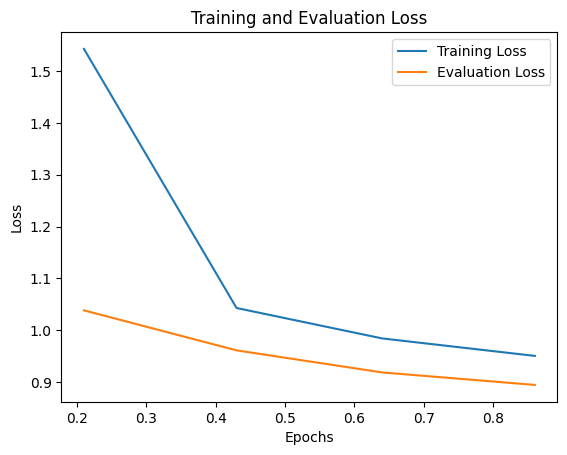

In [104]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

df = pd.DataFrame(trainer.state.log_history)
df.to_csv("./ice-gpt2/log_history.csv")

training_loss_data = []
eval_loss_data = []
for i in range(len(df)):
    row = df.iloc[i]
    epoch, train_loss, eval_loss = row["epoch"], row["loss"], row["eval_loss"]

    if not np.isnan(eval_loss):
        eval_loss_data.append((epoch, eval_loss))

    if not np.isnan(train_loss):
        training_loss_data.append((epoch, train_loss))

# Extract x and y values for training and evaluation losses
training_epochs, training_losses = zip(*training_loss_data)
eval_epochs, eval_losses = zip(*eval_loss_data)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the training loss
ax.plot(training_epochs, training_losses, label='Training Loss')

# Plot the evaluation loss
ax.plot(eval_epochs, eval_losses, label='Evaluation Loss')

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Evaluation Loss')

# Add a legend
ax.legend()

# Display the plot
plt.show()